# W1D1: Model Types

Tutorial 1: "What" is a good description of the inter-spike interval (ISI)? \
Tutorial 2: "How" is the ISI generated in neurons? \
Tutorial 3: "Why" is having the ISI the best thing for neurons to do?

## Tutorial 1: "What" Models

https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Tutorial1.html

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
def plot_isis(single_neuron_isis):
    plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
    plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
    plt.xlabel("ISI duration (s)")
    plt.ylabel("Number of spikes")
    plt.legend()

In [88]:
# download spike data from Steinmetz dataset
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
    print('Failed to download data')
else:
      spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

### Section 1: Exploring the Steinmetz dataset

We consider a subset of data from a study of Steinmetz et al. (2019). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode’s measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to `spike_times` in the preceding setup.

In [15]:
print(type(spike_times))
print(np.shape(spike_times))
print(np.shape(spike_times[0]))
print(np.shape(spike_times[1]))
print(spike_times[0][:5])

<class 'numpy.ndarray'>
(734,)
(826,)
(2818,)
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


In [16]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(n) for n in spike_times]

print(f'Number of neurons: {n_neurons}')
print(f'Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}')

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


#### Counting and plotting total spike counts

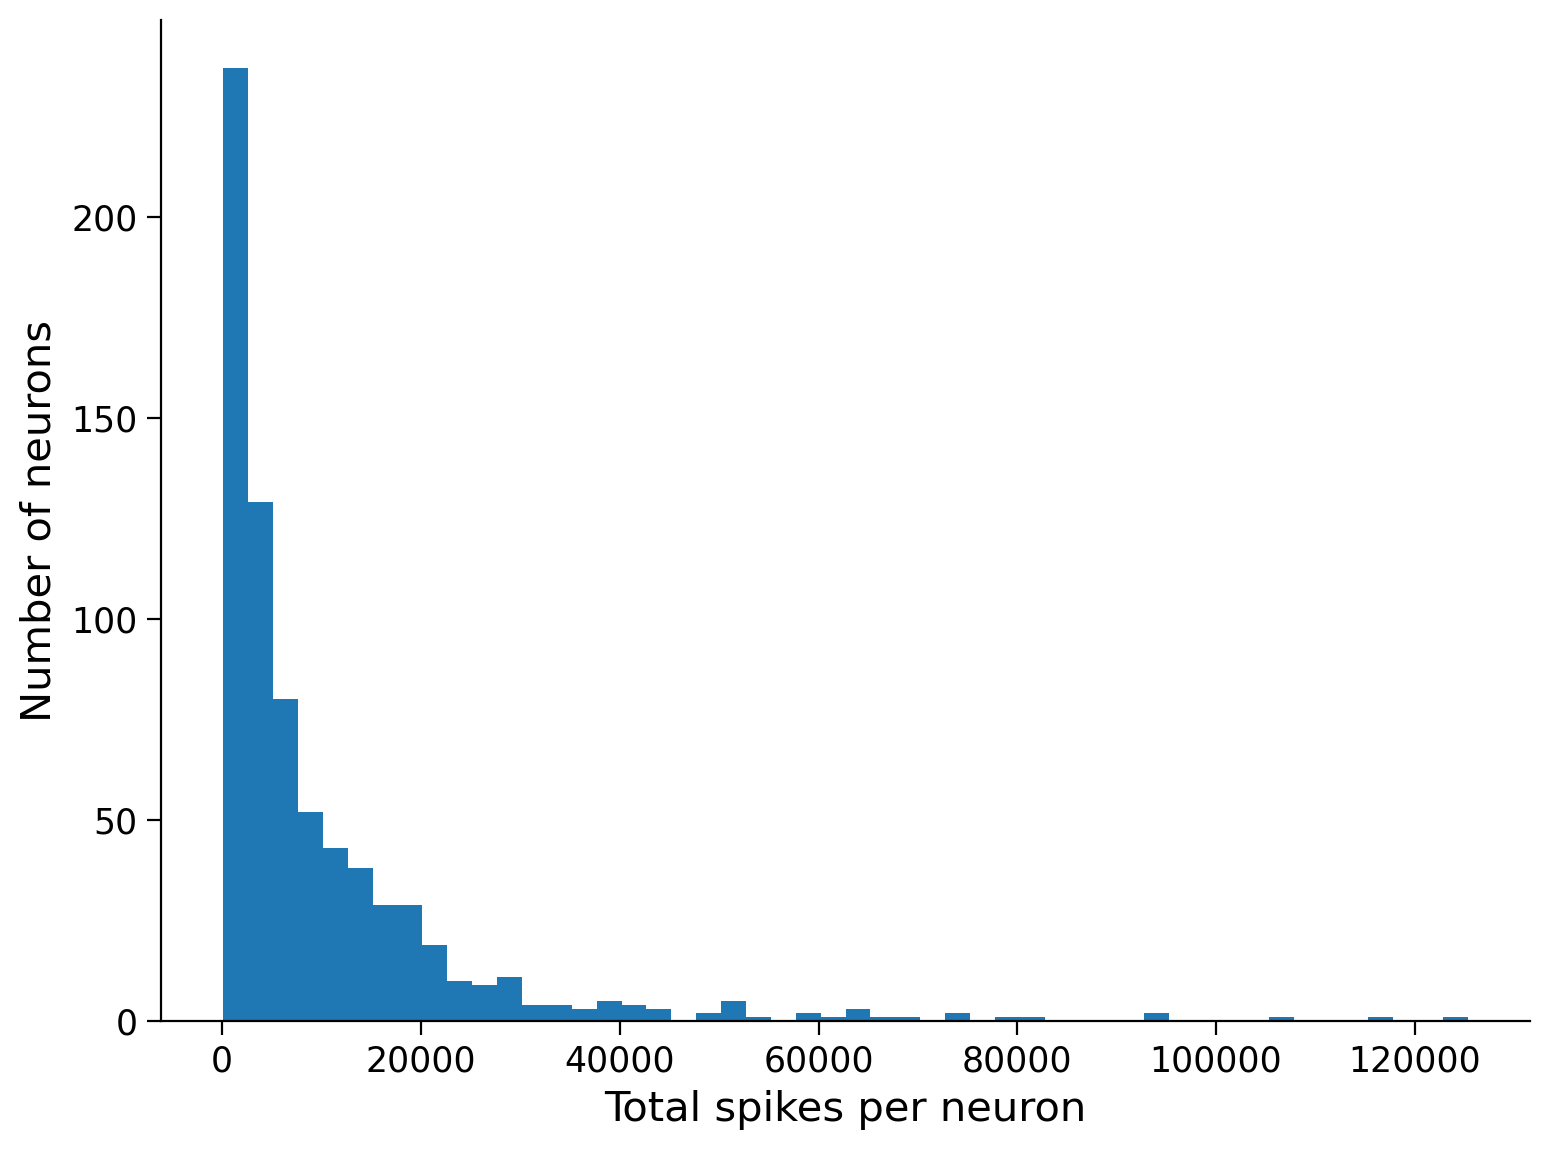

In [17]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

format specification docs: https://docs.python.org/3.6/library/string.html#format-specification-mini-language

In [27]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f'{frac_below_mean:2.1%} of neurons are below the mean') # print percentage with one decimal place

68.0% of neurons are below the mean


#### Comparing mean and median neurons

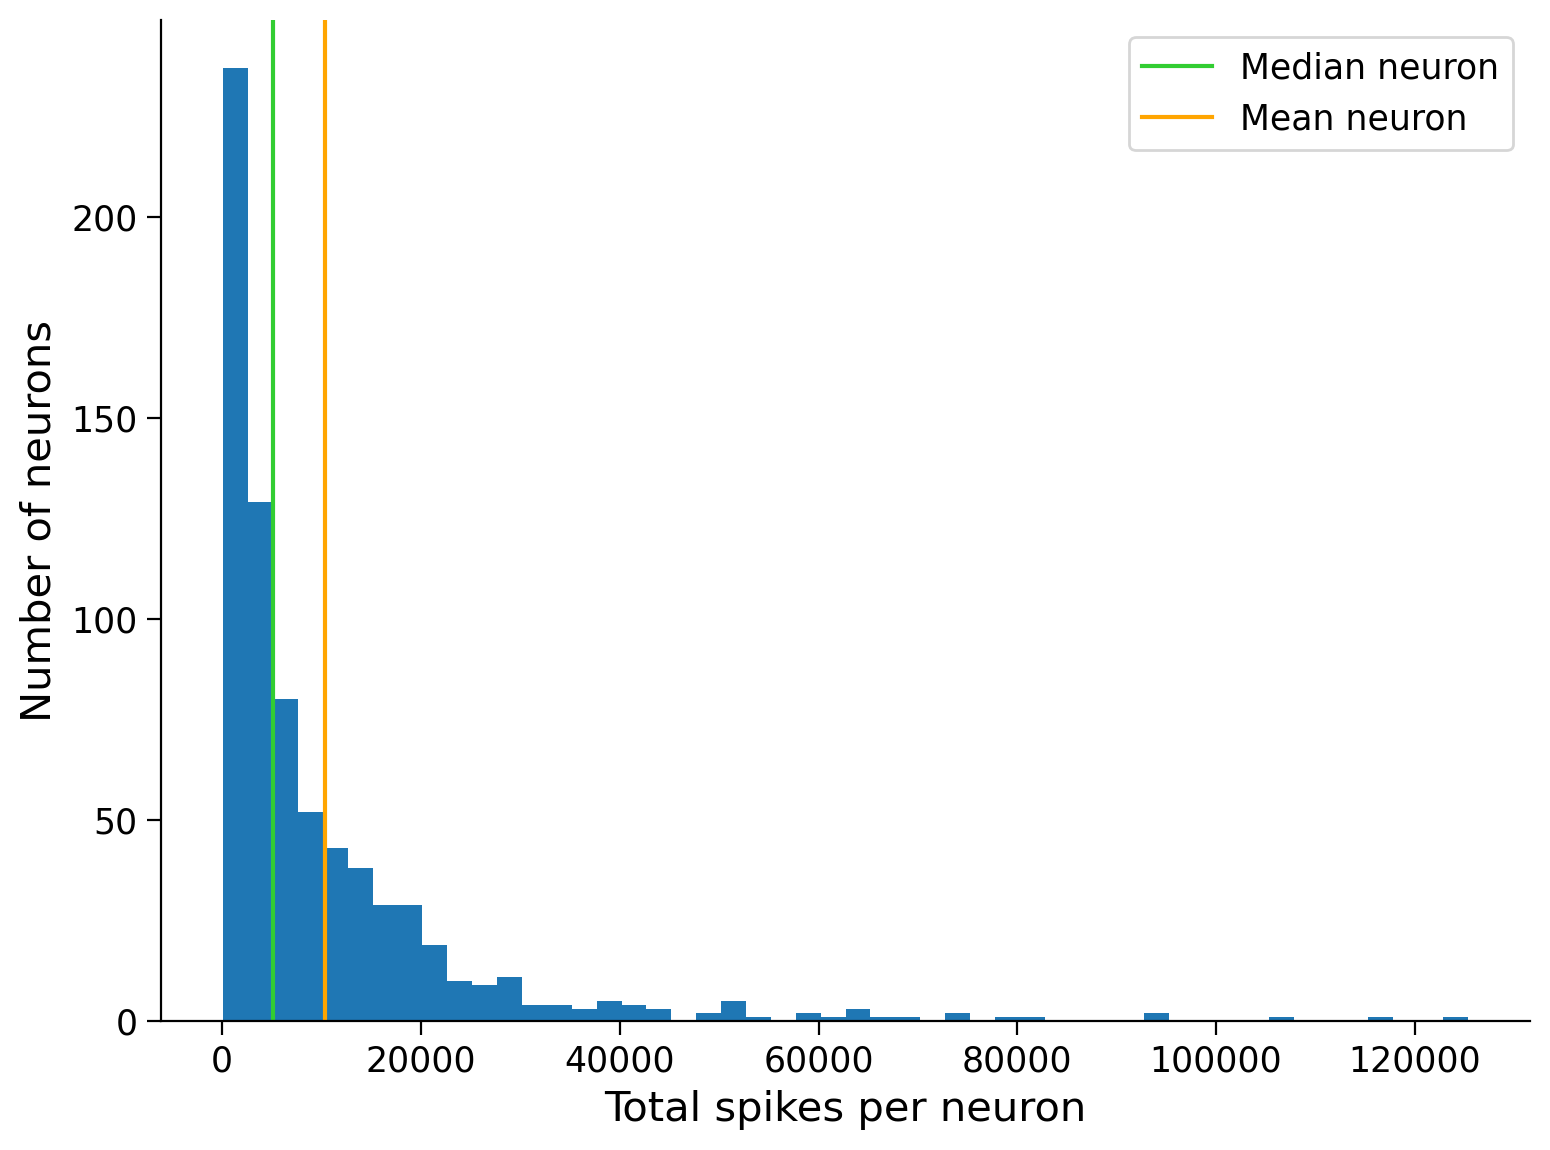

In [30]:
median_spike_count = np.median(total_spikes_per_neuron)

# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype='stepfilled')
plt.axvline(median_spike_count, color='limegreen', label='Median neuron')
plt.axvline(mean_spike_count, color='orange', label='Mean neuron')
plt.xlabel('Total spikes per neuron')
plt.ylabel('Number of neurons')
plt.legend()

### Section 2: Visualizing neuronal spiking activity

#### Getting a subset of the data

In [32]:
def restrict_spike_times(spike_times, interval):
    """Given a spike_time dataset, restrict to spikes within given interval.

    Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

    Returns:
    np.ndarray: like `spike_times`, but only within `interval`
    """
    interval_spike_times = []
    for spikes in spike_times:
        interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
        interval_spike_times.append(spikes[interval_mask])
    return np.array(interval_spike_times, object)

In [33]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
    np.ndarray: like `spike_times`, but only within `interval`



In [34]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

In [36]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f'{frac_interval_spikes:.2%} of the total spikes are in the interval')

0.33% of the total spikes are in the interval


In [38]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f'{frac_interval_time:.2%} of the total time is in the interval')

0.37% of the total time is in the interval


#### Plotting spike trains and rasters

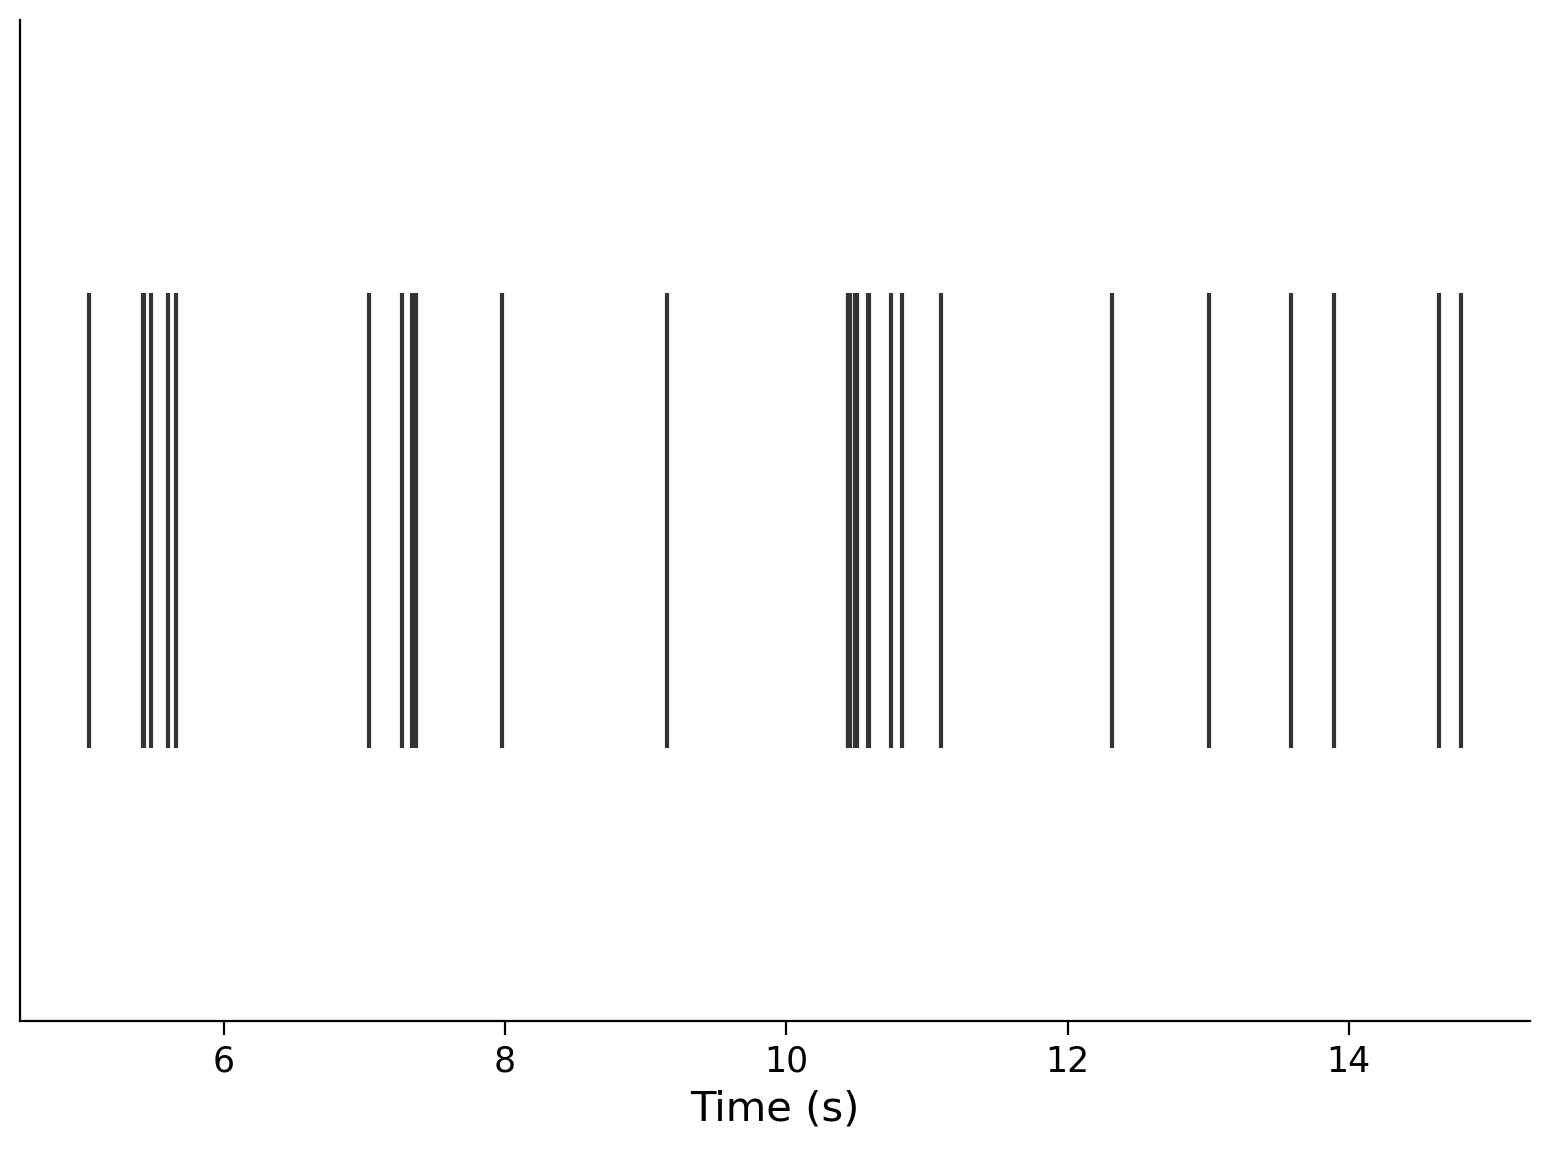

In [43]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color='.2')
plt.xlabel('Time (s)')
plt.yticks([]);

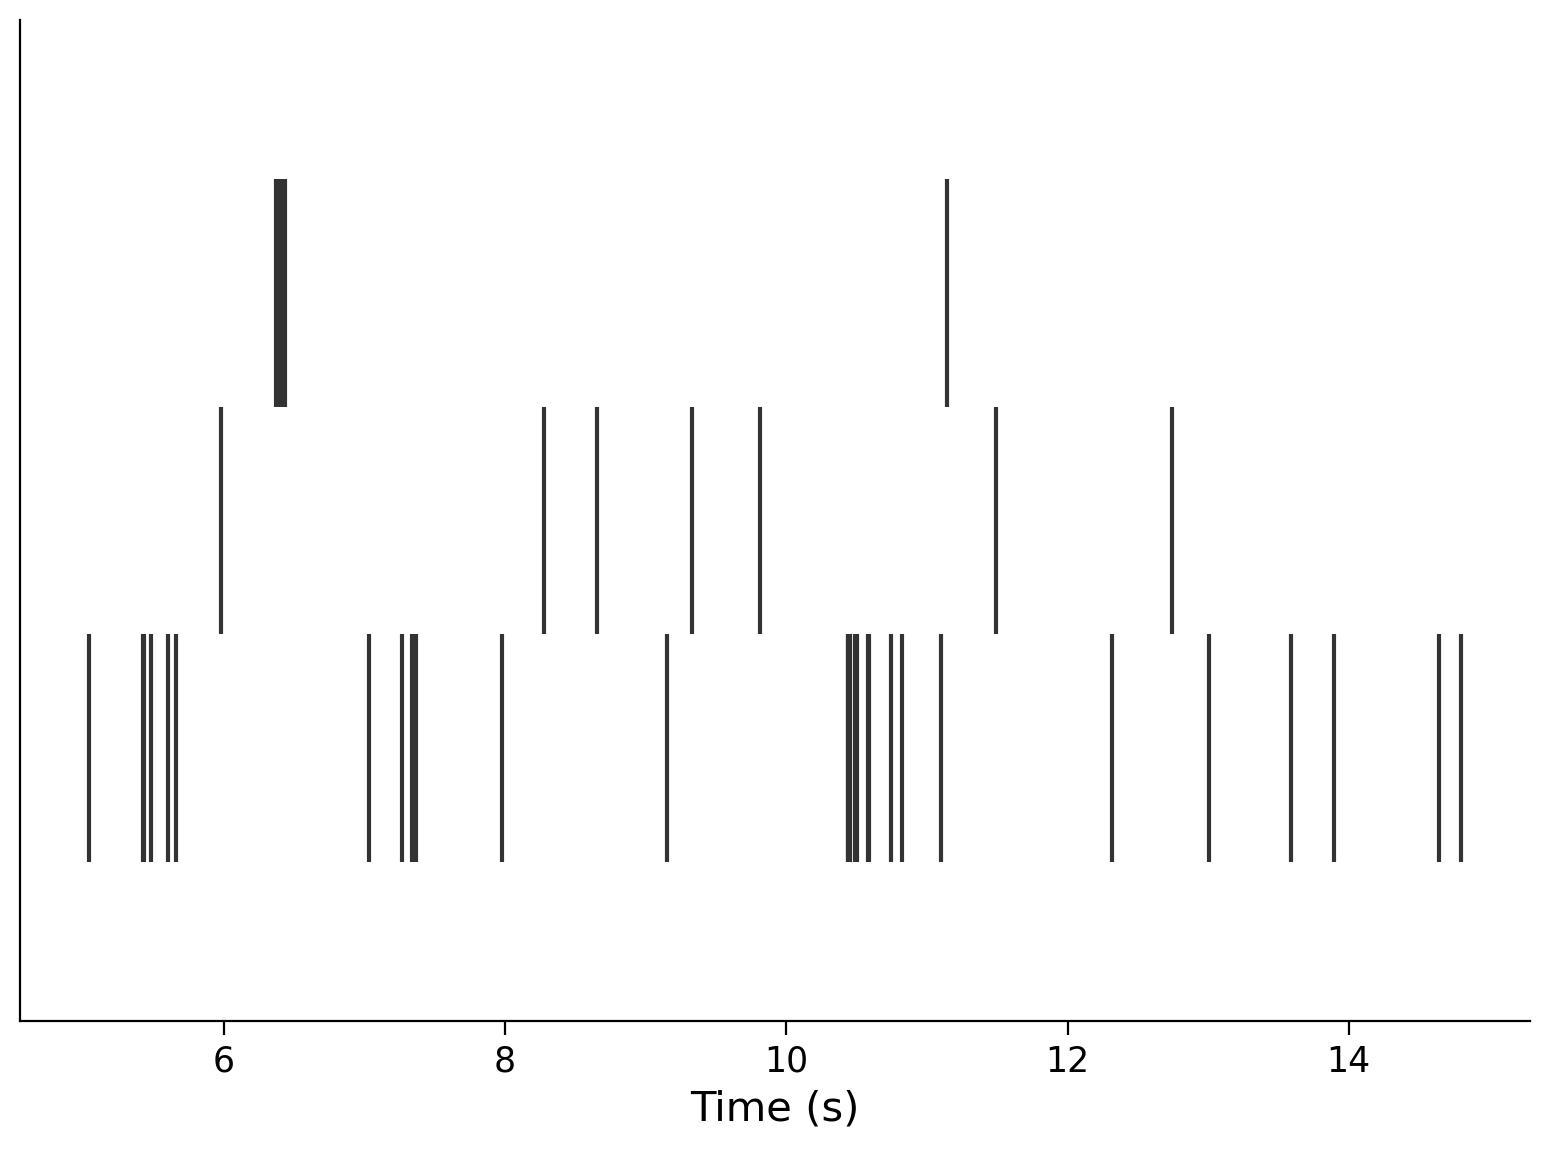

In [46]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color='.2')
plt.xlabel('Time (s)')
plt.yticks([]);

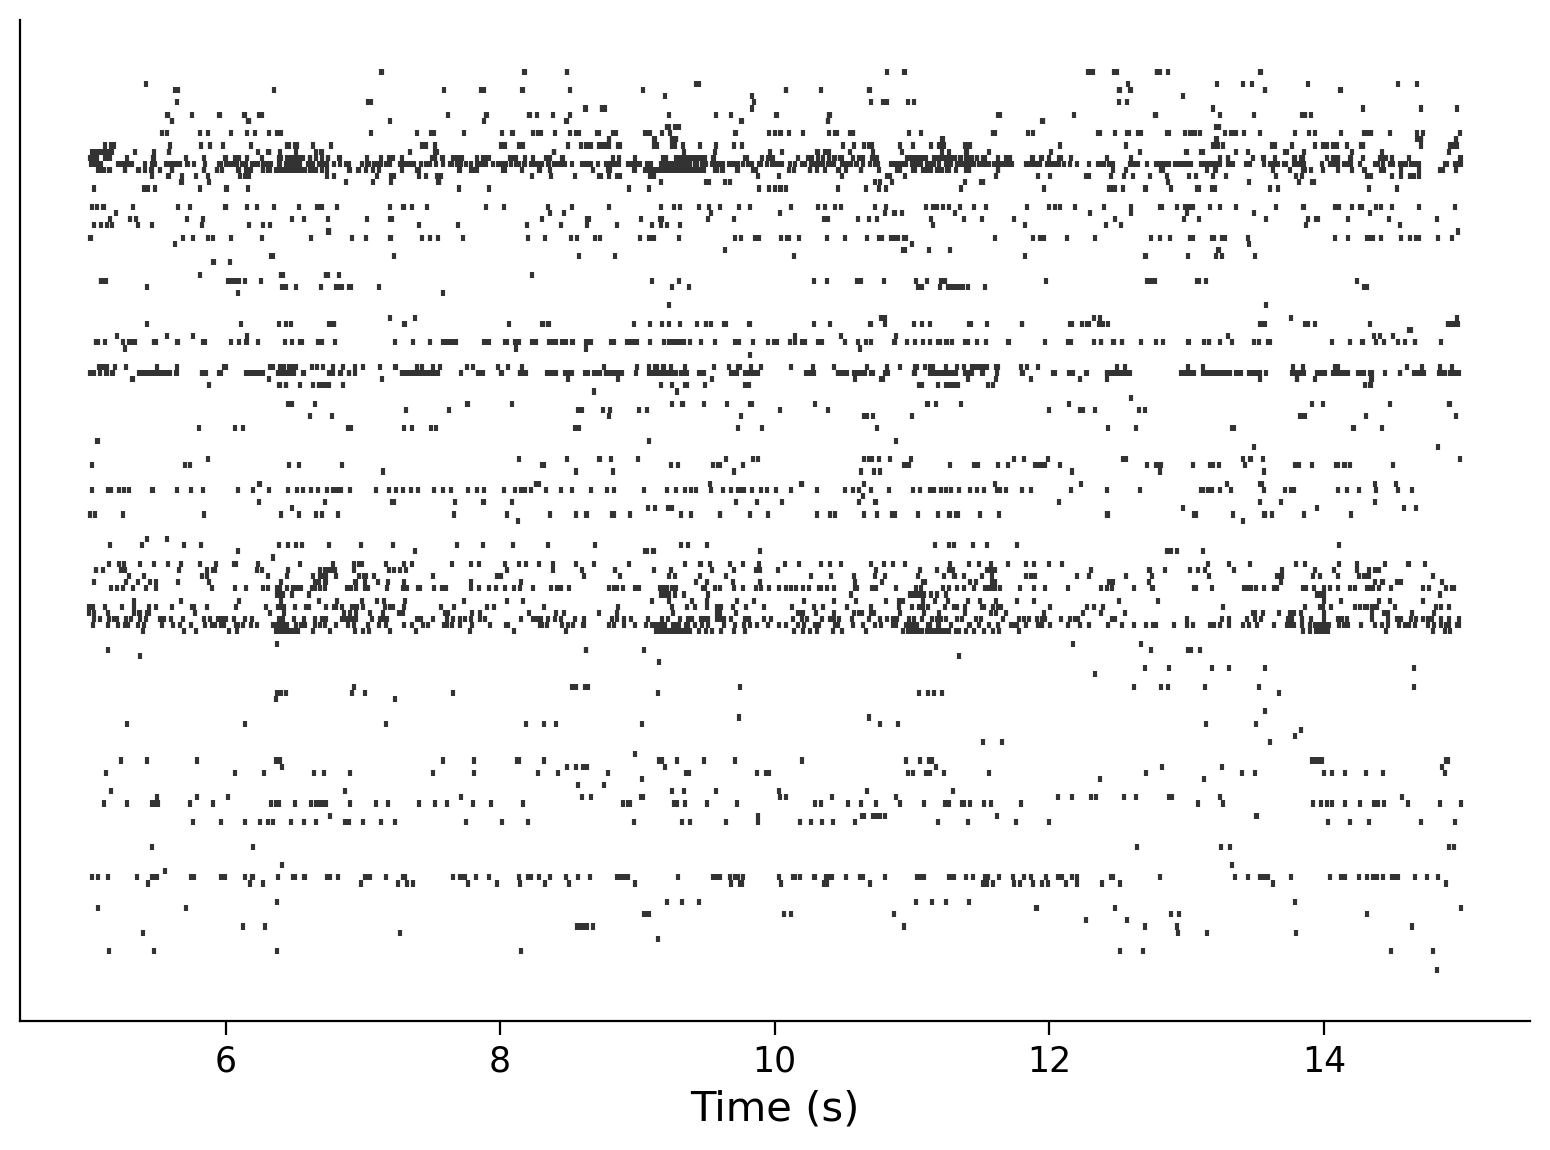

In [47]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color='.2')
plt.xlabel('Time (s)')
plt.yticks([]);

### Section 3: Inter-spike intervals and their distributions

#### Distribution of ISIs for a single neuron

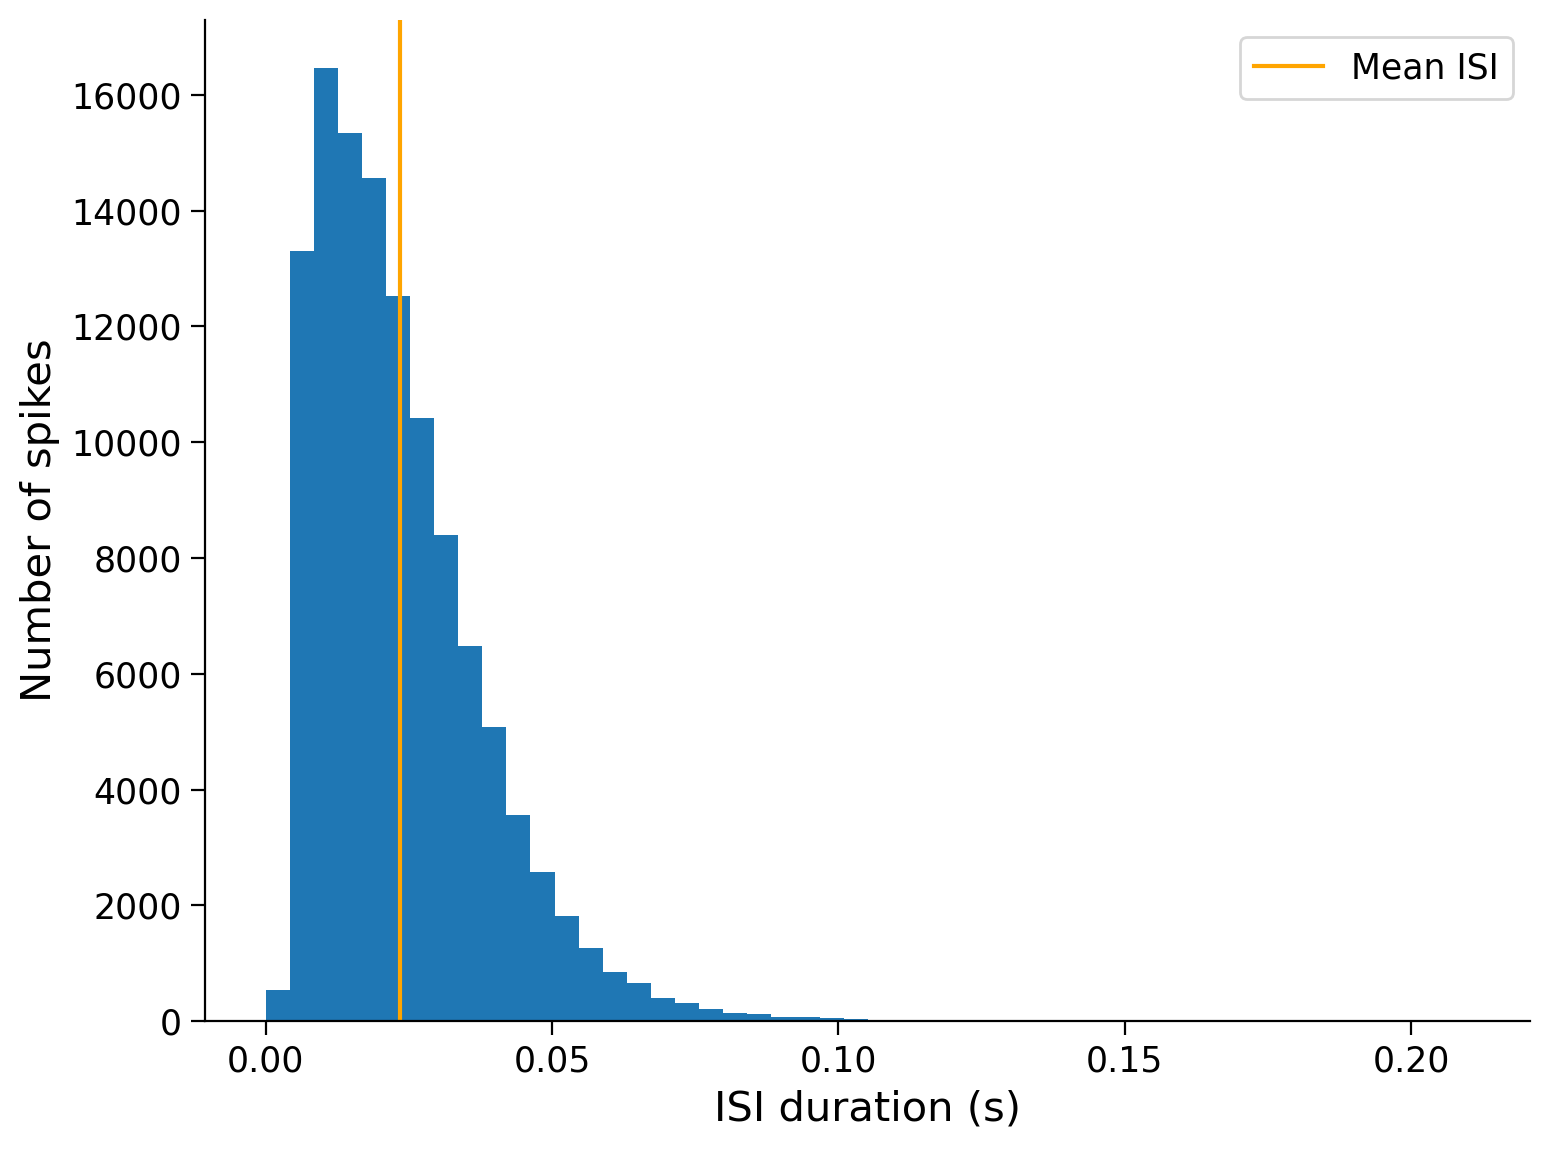

In [50]:
def compute_single_neuron_isis(spike_times, neuron_idx):
    """Compute a vector of ISIs for a single neuron given spike times.

    Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

    Returns:
    isis (1D array): Duration of time between each spike from one neuron.
    """

    # Extract the spike times for the specified neuron
    single_neuron_spikes = spike_times[neuron_idx]

    # Compute the ISIs for this set of spikes
    isis = np.diff(single_neuron_spikes) # computes discrete differences along an array

    return isis

plot_isis(compute_single_neuron_isis(spike_times, neuron_idx=283))

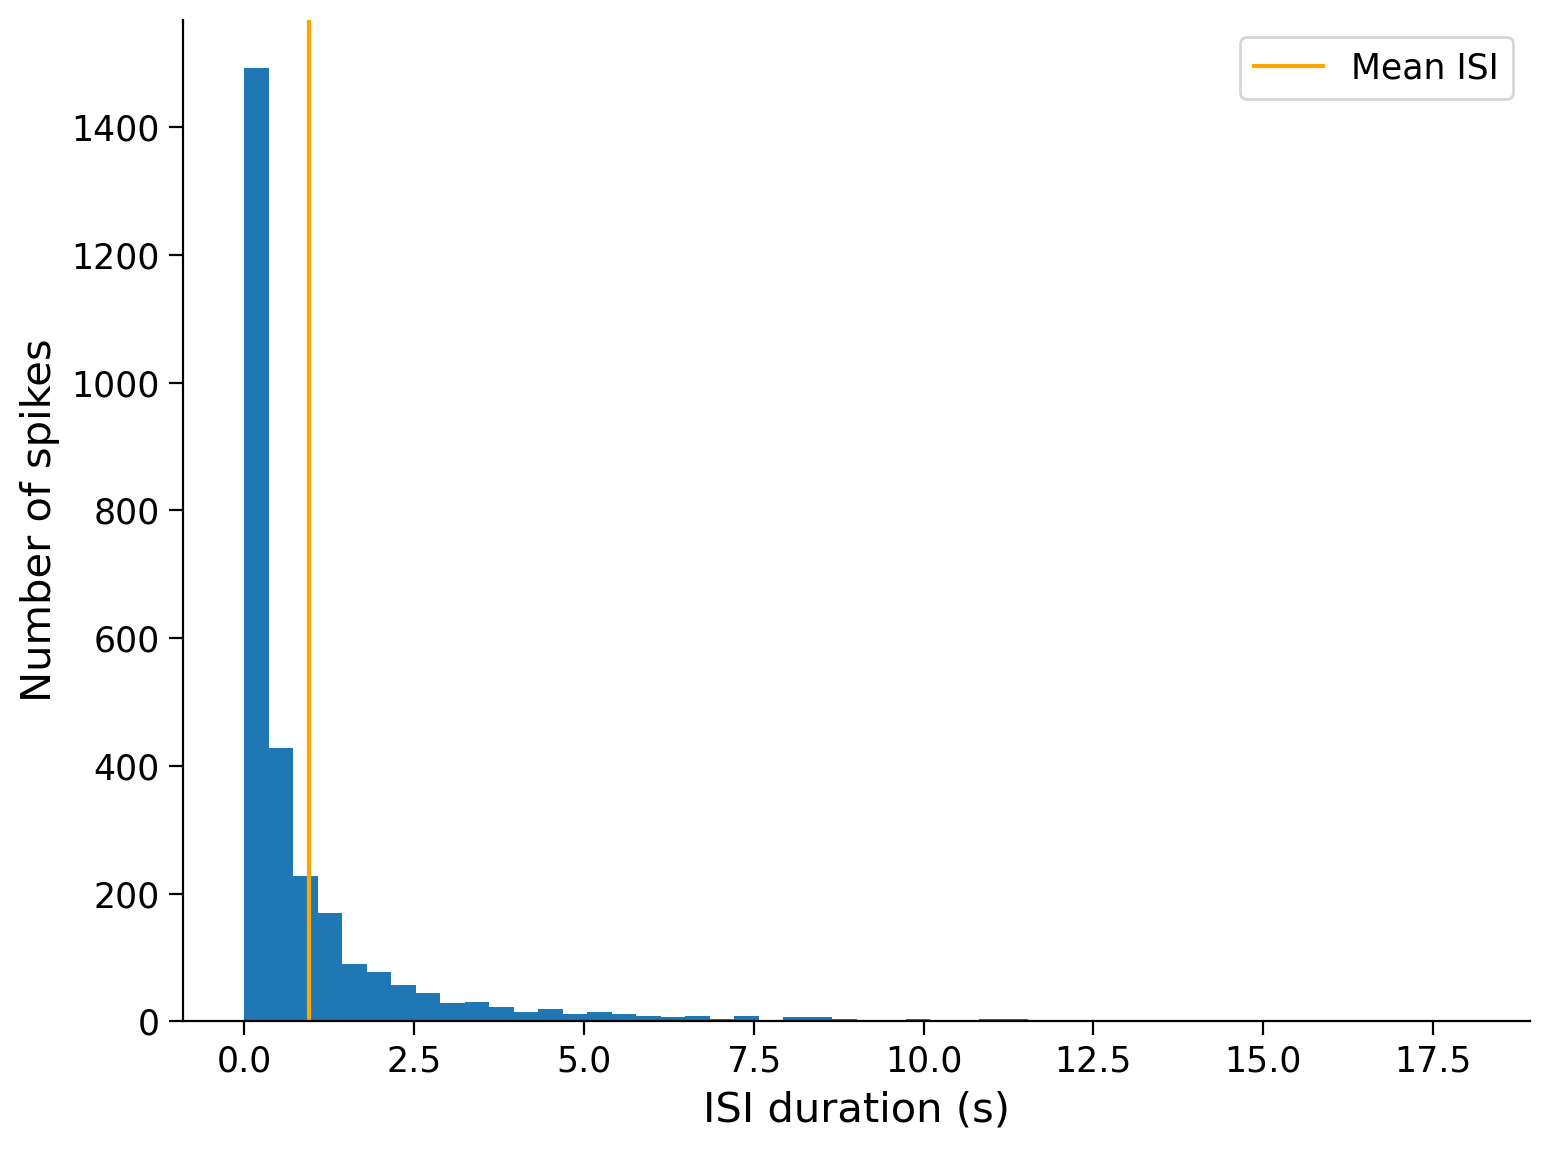

In [51]:
plot_isis(compute_single_neuron_isis(spike_times, neuron_idx=1))

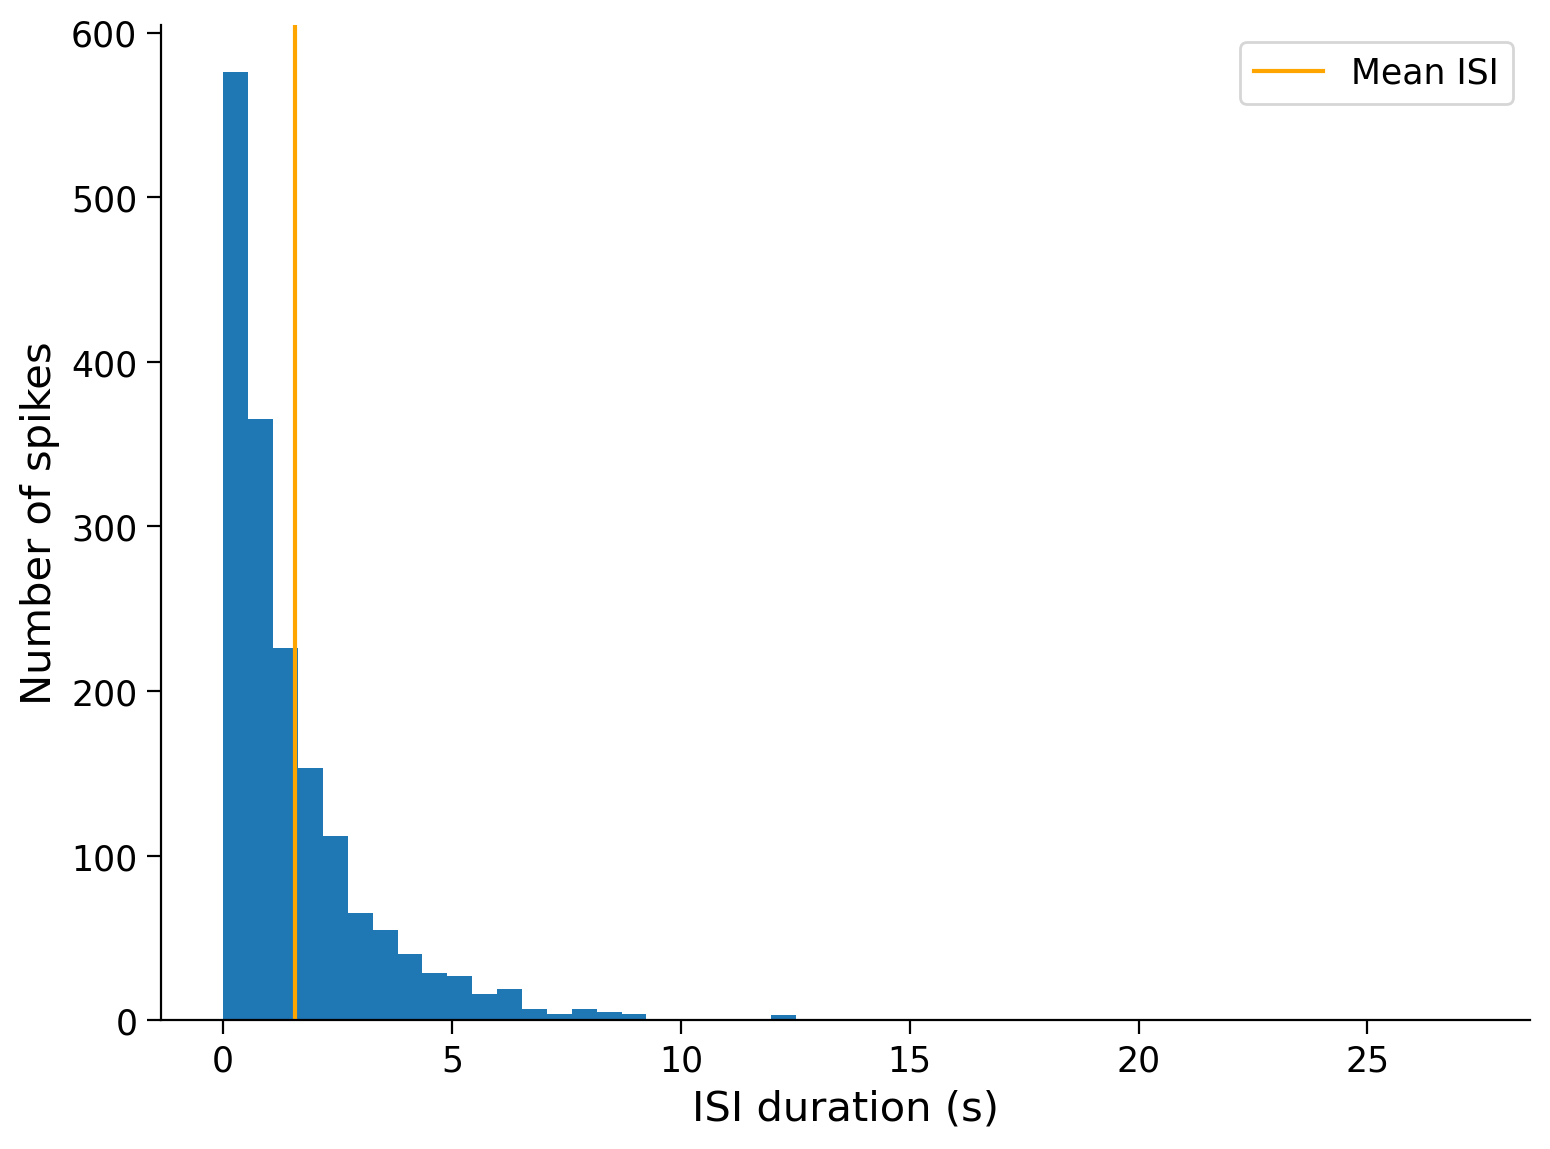

In [52]:
plot_isis(compute_single_neuron_isis(spike_times, neuron_idx=11))

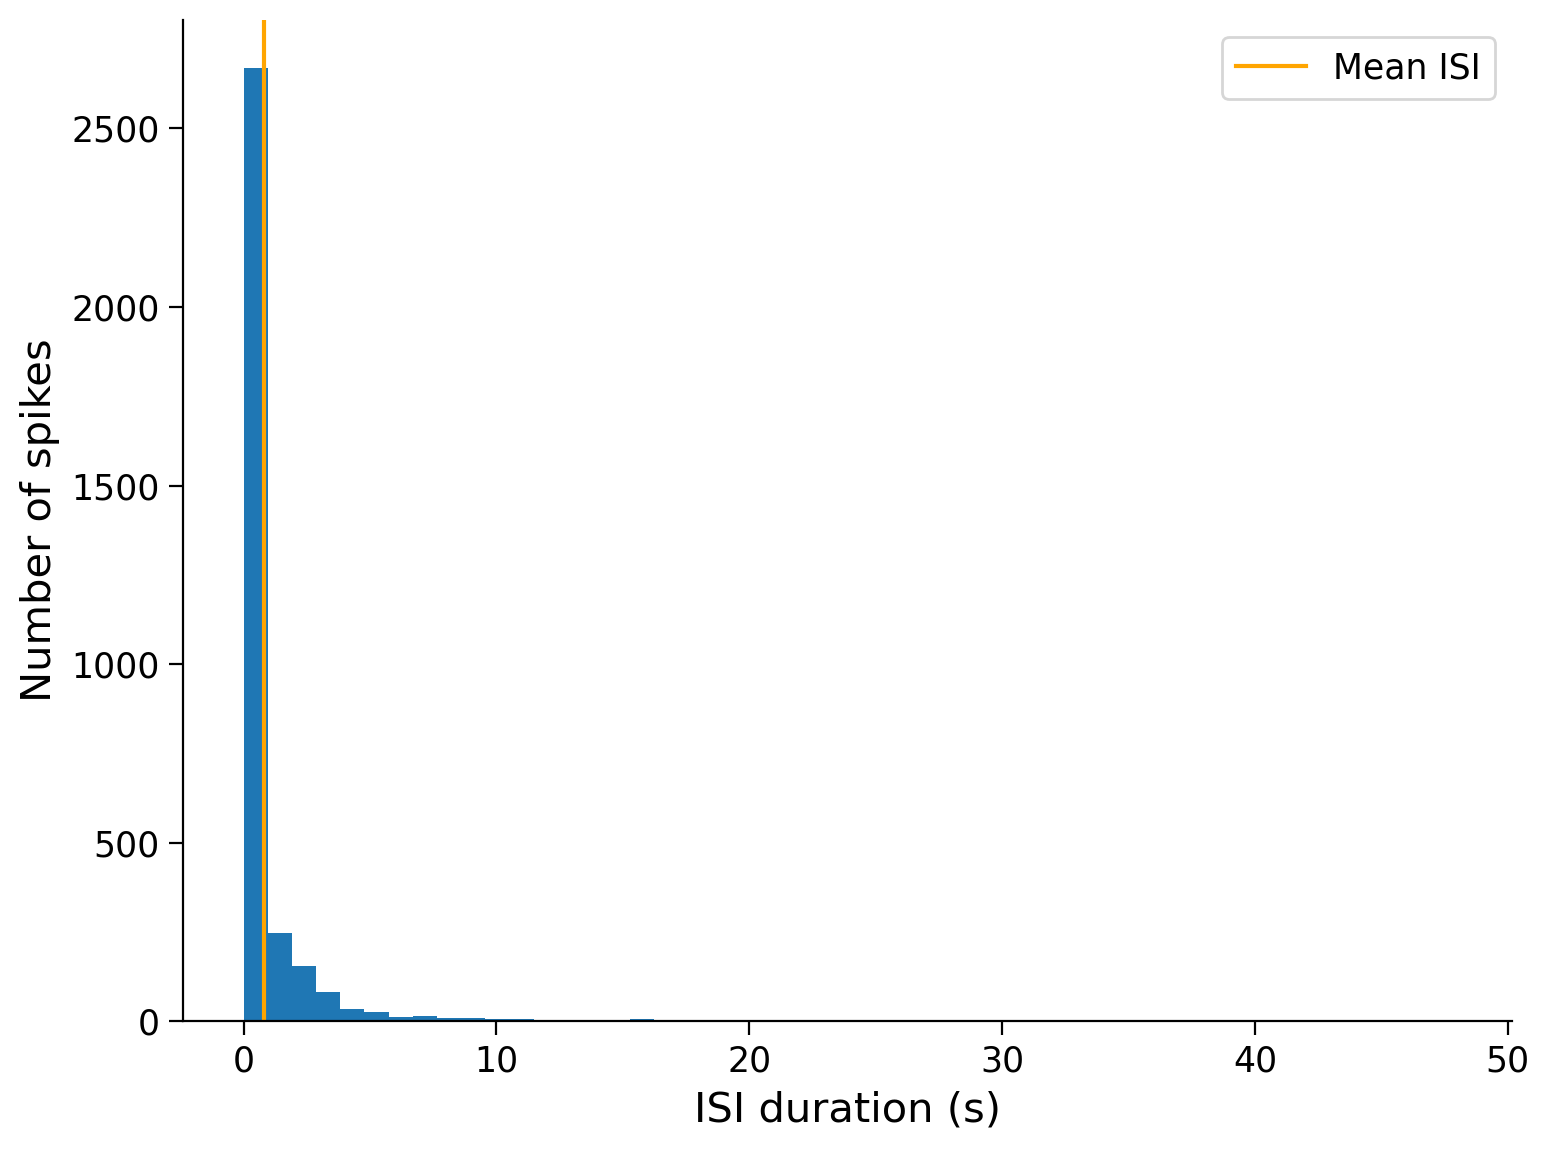

In [53]:
plot_isis(compute_single_neuron_isis(spike_times, neuron_idx=51))

### Section 4: What is the functional form of an ISI distribution?

In [54]:
def exponential(xs, scale, rate, x0):
    """A simple parameterized exponential function, applied element-wise.

    Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

    """
    ys = scale * np.exp(rate * (xs - x0))
    return ys

def inverse(xs, scale, x0):
    """A simple parameterized inverse function (`1/x`), applied element-wise.

    Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

    """
    ys = scale / (xs - x0)
    return ys

def linear(xs, slope, y0):
    """A simple linear function, applied element-wise.

    Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

    """
    ys = slope * xs + y0
    return ys

In [95]:
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
    """Helper function for plotting function fits with interactive sliders."""
    func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
    )
    f, ax = plt.subplots()
    ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
    xs = np.linspace(1e-10, edges.max())
    for name, function in functions.items():
        ys = function(xs, *func_params[name])
        ax.plot(xs, ys, lw=3, color=colors[name], label=name);
        ax.set(
          xlim=(edges.min(), edges.max()),
          ylim=(0, counts.max() * 1.1),
          xlabel="ISI (s)",
          ylabel="Number of spikes",
        )
    ax.legend()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

## Tutorial 2: "How" Models

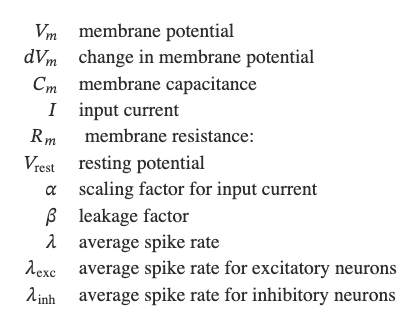

### Section 1: The linear integrate-and-fire neuron

In [99]:
def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
    """Plot a step histogram given counts over bins."""
    if ax is None:
        _, ax = plt.subplots()

    # duplicate the first element of `counts` to match bin edges
    counts = np.insert(counts, 0, counts[0])

    ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
    ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

    for x in vlines:
        ax.axvline(x, color='r', linestyle='dotted')  # vertical line

    if ax_args is None:
        ax_args = {}

  # heuristically set max y to leave a bit of room
    ymin, ymax = ax_args.get('ylim', [None, None])
    if ymax is None:
        ymax = np.max(counts)
        if ax_args.get('yscale', 'linear') == 'log':
            ymax *= 1.5
        else:
            ymax *= 1.1
        if ymin is None:
            ymin = 0

    if ymax == ymin:
        ymax = None

    ax_args['ylim'] = [ymin, ymax]

    ax.set(**ax_args)
    ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # membrane voltage trace
    ax1.plot(v[0:100])
    ax1.set(xlabel='Time', ylabel='Voltage')
    # plot spike events
    for x in spike_times:
        if x >= 100:
            break
    ax1.axvline(x, color='red')

    # ISI distribution
    if len(spike_times)>1:
        isi = np.diff(spike_times)
        n_bins = np.arange(isi.min(), isi.max() + 2) - .5
        counts, bins = np.histogram(isi, n_bins)
        vlines = []
        if len(isi) > 0:
            vlines = [np.mean(isi)]
        xmax = max(20, int(bins[-1])+5)
        histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
          'xlabel': 'Inter-spike interval',
          'ylabel': 'Number of intervals',
          'xlim': [0, xmax]
        })
    else:
        ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
    plt.show()

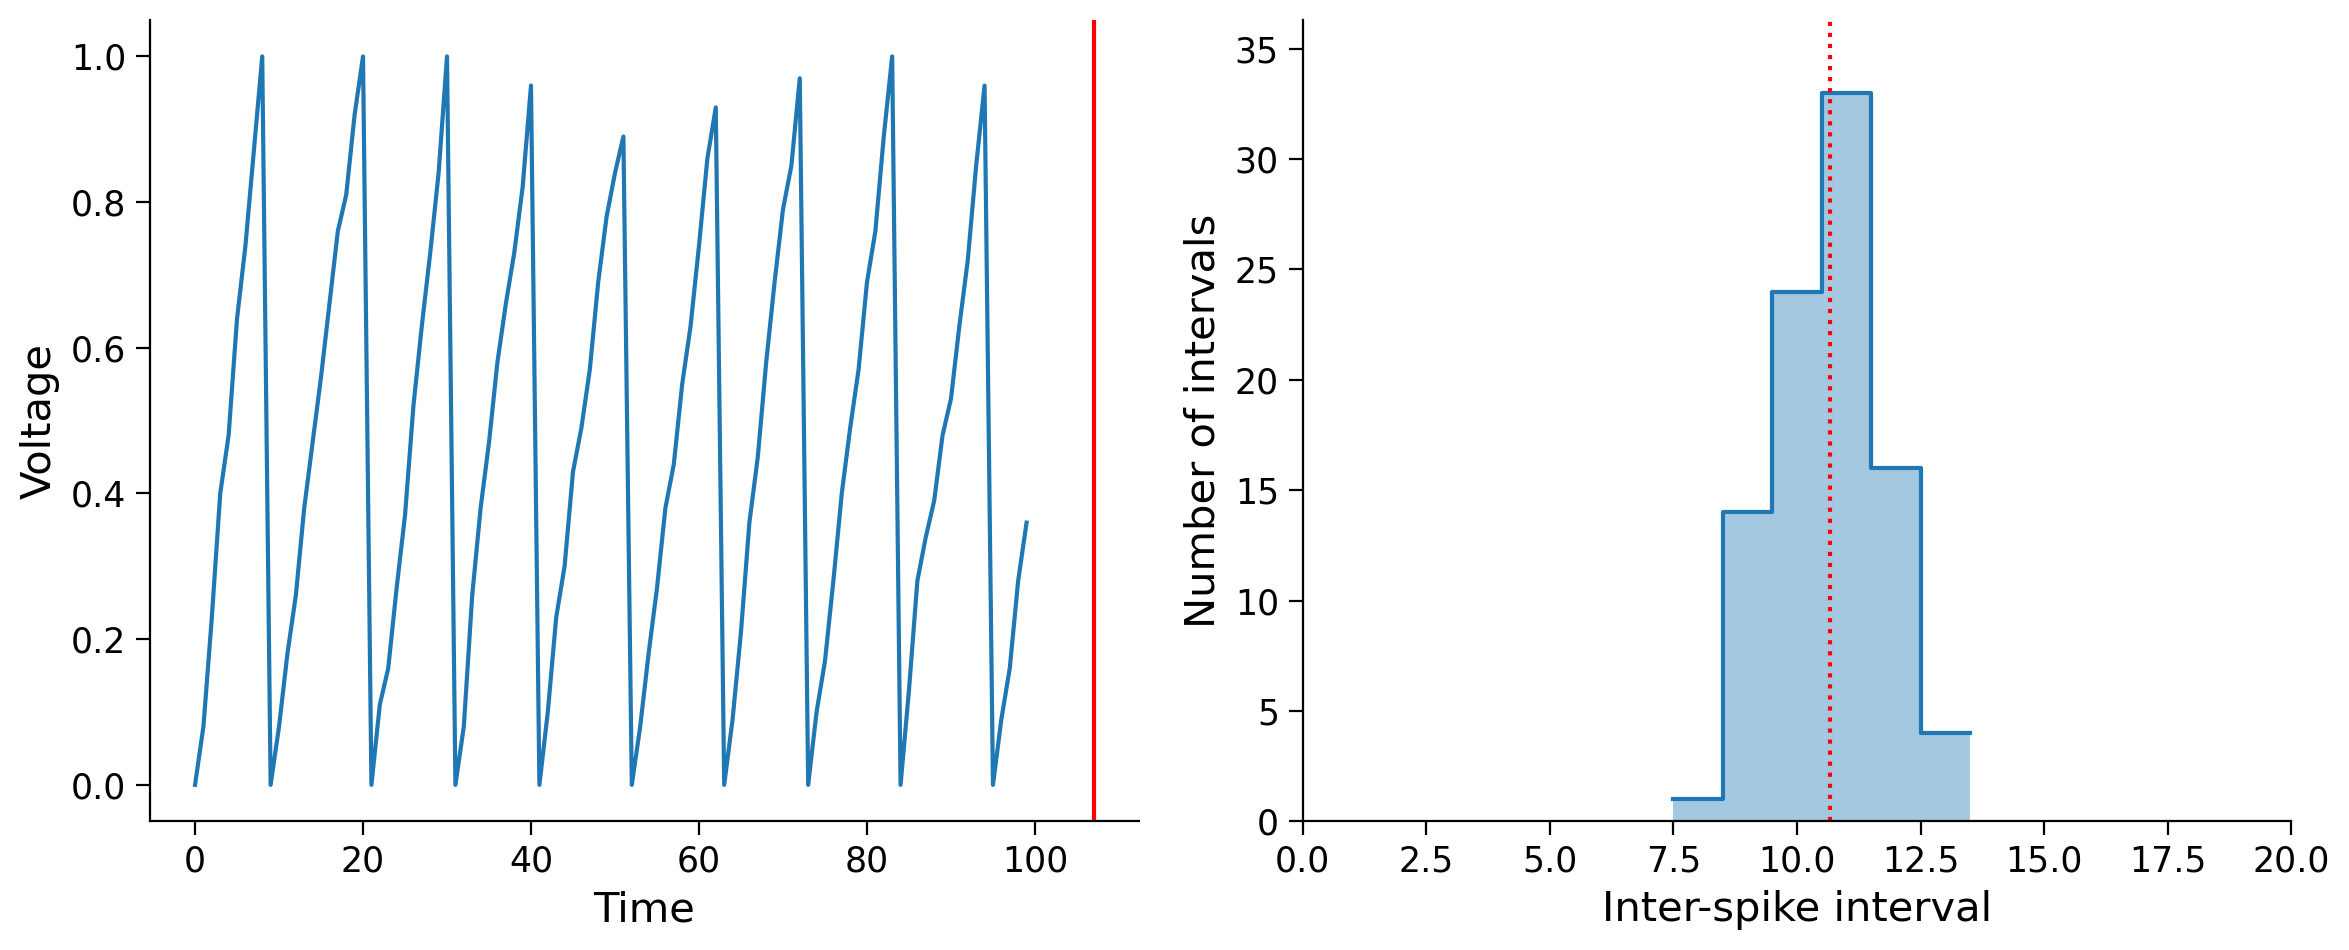

In [100]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
    """ Simulate a linear integrate-and-fire neuron.

    Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

    """
    # Precompute Poisson samples for speed
    exc = stats.poisson(rate).rvs(n_steps)

    # Initialize voltage and spike storage
    v = np.zeros(n_steps)
    spike_times = []

    # Loop over steps
    for i in range(1, n_steps):

        # Update v
        dv = alpha * exc[i]
        v[i] = v[i-1] + dv

        # If spike happens, reset voltage and record
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times_ = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times_)

In [101]:
def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
    exc = stats.poisson(rate).rvs(n_steps)
    v = np.zeros(n_steps)
    spike_times = []
    for i in range(1, n_steps):
        dv = alpha * exc[i]
        v[i] = v[i-1] + dv
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0
    return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
    v, spike_times = _lif_neuron(2000, alpha, rate)
    plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

### Section 2: Inhibitory signals

leak current tendency for neuron to return to resting potential

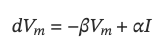

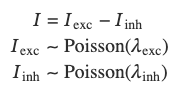

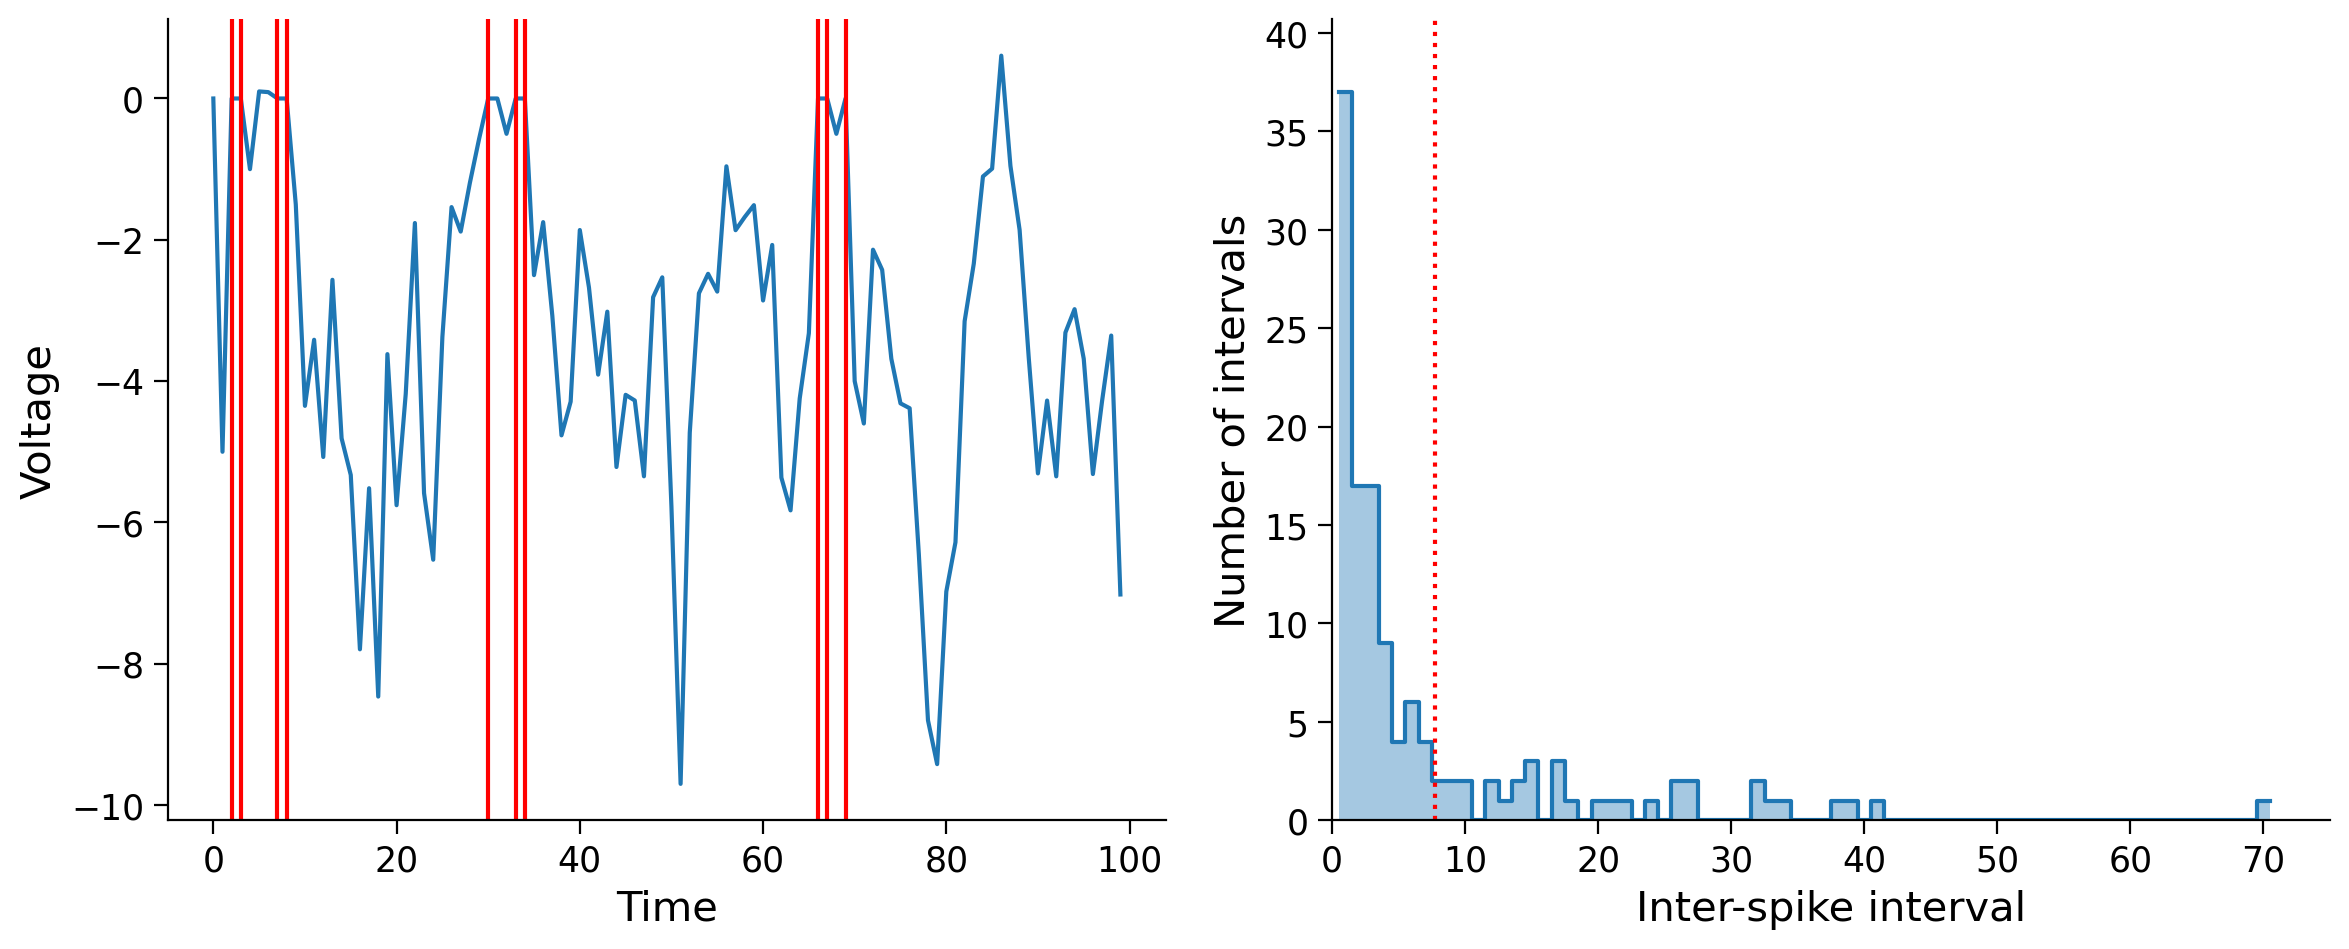

In [68]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
    """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
    and inhibitory inputs.

    Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
    """

    # precompute Poisson samples for speed
    exc = stats.poisson(exc_rate).rvs(n_steps)
    inh = stats.poisson(inh_rate).rvs(n_steps)

    v = np.zeros(n_steps)
    spike_times = []

    for i in range(1, n_steps):

        dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
        spike_times.append(i)
        v[i] = 0

    return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

In [102]:
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
    """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
    and inhibitory inputs.

    Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
    """
    # precompute Poisson samples for speed
    exc = stats.poisson(exc_rate).rvs(n_steps)
    inh = stats.poisson(inh_rate).rvs(n_steps)

    v = np.zeros(n_steps)
    spike_times = []
    for i in range(1, n_steps):
        dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
        v[i] = v[i-1] + dv
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
    v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
    plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

## Tutorial 3: "Why" Models

In [73]:
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [74]:
def plot_pmf(pmf,isi_range):
    """Plot the probability mass function."""
    ymax = max(0.2, 1.05 * np.max(pmf))
    pmf_ = np.insert(pmf, 0, pmf[0])
    plt.plot(bins, pmf_, drawstyle="steps")
    plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
    plt.title(f"Neuron {neuron_idx}")
    plt.xlabel("Inter-spike interval (s)")
    plt.ylabel("Probability mass")
    plt.xlim(isi_range);
    plt.ylim([0, ymax])

**deterministic distribution**: all of the mass is concentrated on a single event

**entropy**

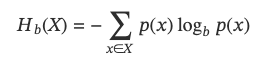

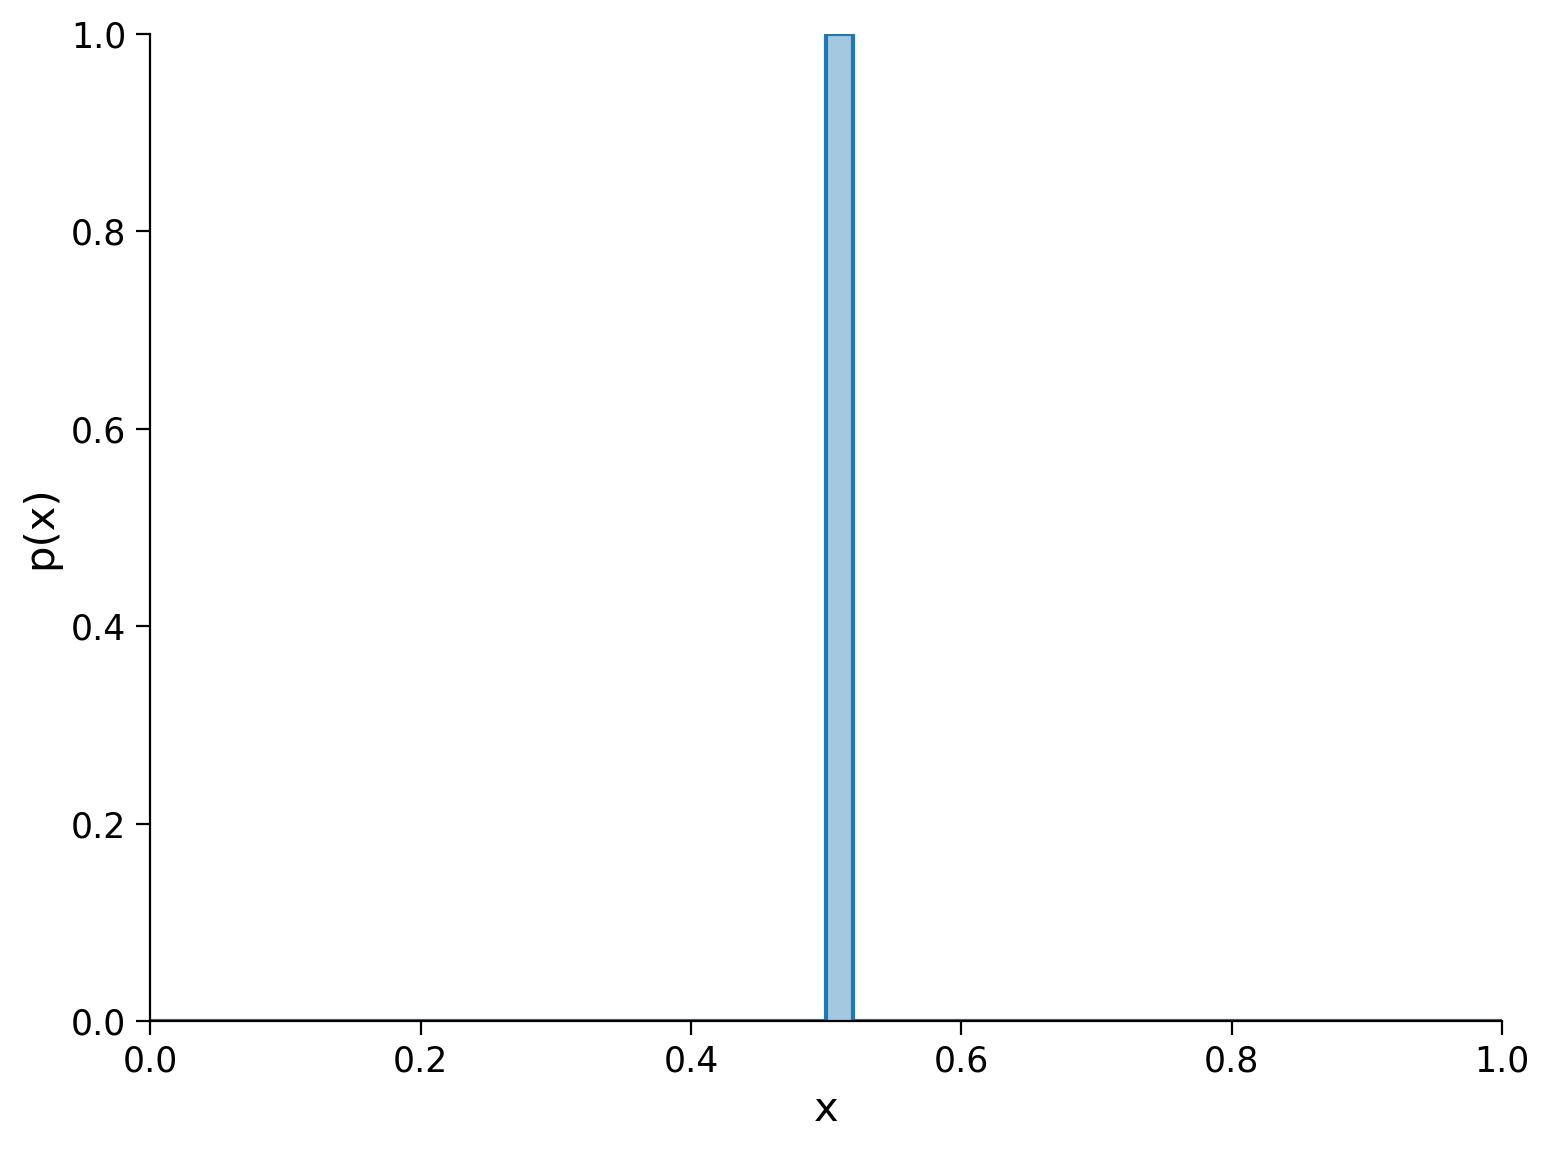

In [76]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

In [78]:
def entropy(pmf):
    """Given a discrete distribution, return the Shannon entropy in bits.

    This is a measure of information in the distribution. For a totally
    deterministic distribution, where samples are always found in the same bin,
    then samples from the distribution give no more information and the entropy
    is 0.

    For now this assumes `pmf` arrives as a well-formed distribution (that is,
    `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

    Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
    Returns:
    h (number): The entropy of the distribution in `pmf`.

    """

    # reduce to non-zero entries to avoid an error from log2(0)
    pmf = pmf[pmf > 0]

    # implement the equation for Shannon entropy (in bits)
    h = -np.sum(pmf * np.log2(pmf))

    # return the absolute value (avoids getting a -0 result)
    return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


1.00 bits


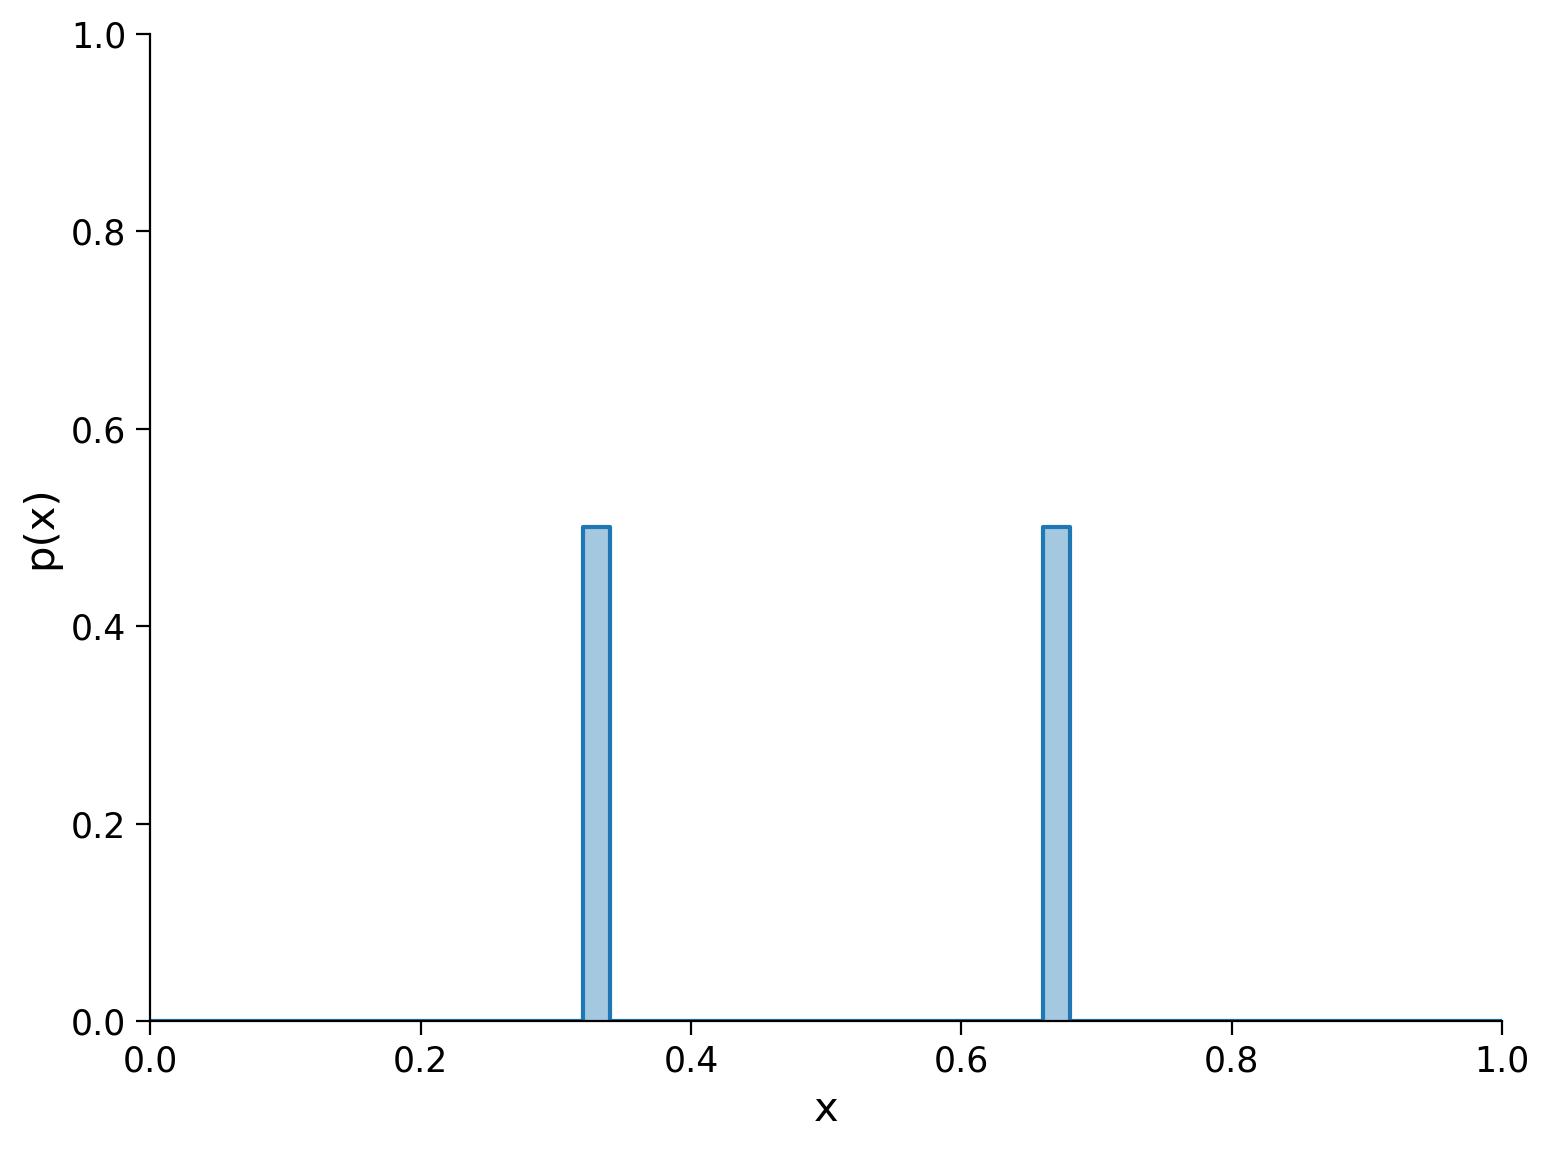

In [80]:
pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);
print(f"{entropy(pmf_):.2f} bits")

Entropy when probability mass split equally among N points. For N discrete points, the uniform distribution is the distribution with the highest entropy

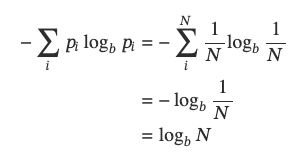

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron’s mean firing rate. If a neuron has a fixed energy budget and each of its spikes has the same energy cost, then by fixing the mean firing rate, we are normalizing for energy expenditure. This provides a basis for comparing the entropy of different ISI distributions. In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?

In [81]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

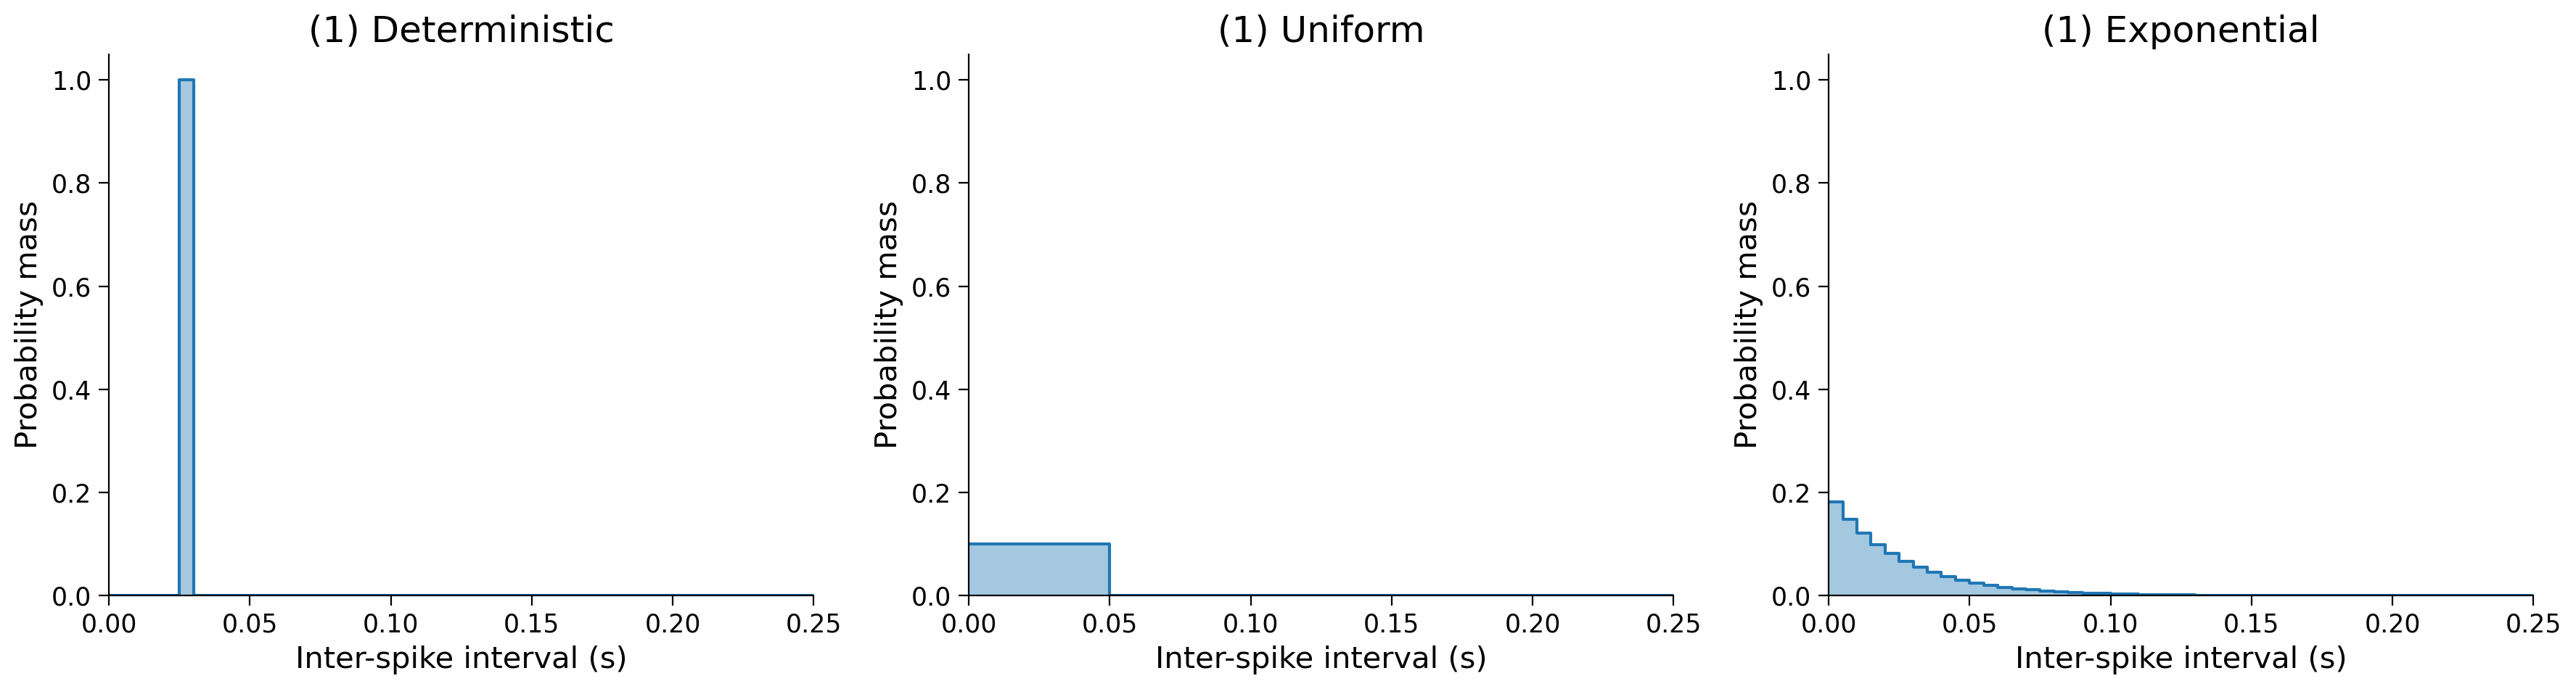

In [82]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
    pmf_ = np.insert(pmf_, 0, pmf_[0])
    ax.plot(bins, pmf_, drawstyle="steps")
    ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
    ax.set_title(label)
    ax.set_xlabel("Inter-spike interval (s)")
    ax.set_ylabel("Probability mass")
    ax.set_xlim(isi_range);
    ax.set_ylim(ylim);

In [83]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


#### Probability Mass Function

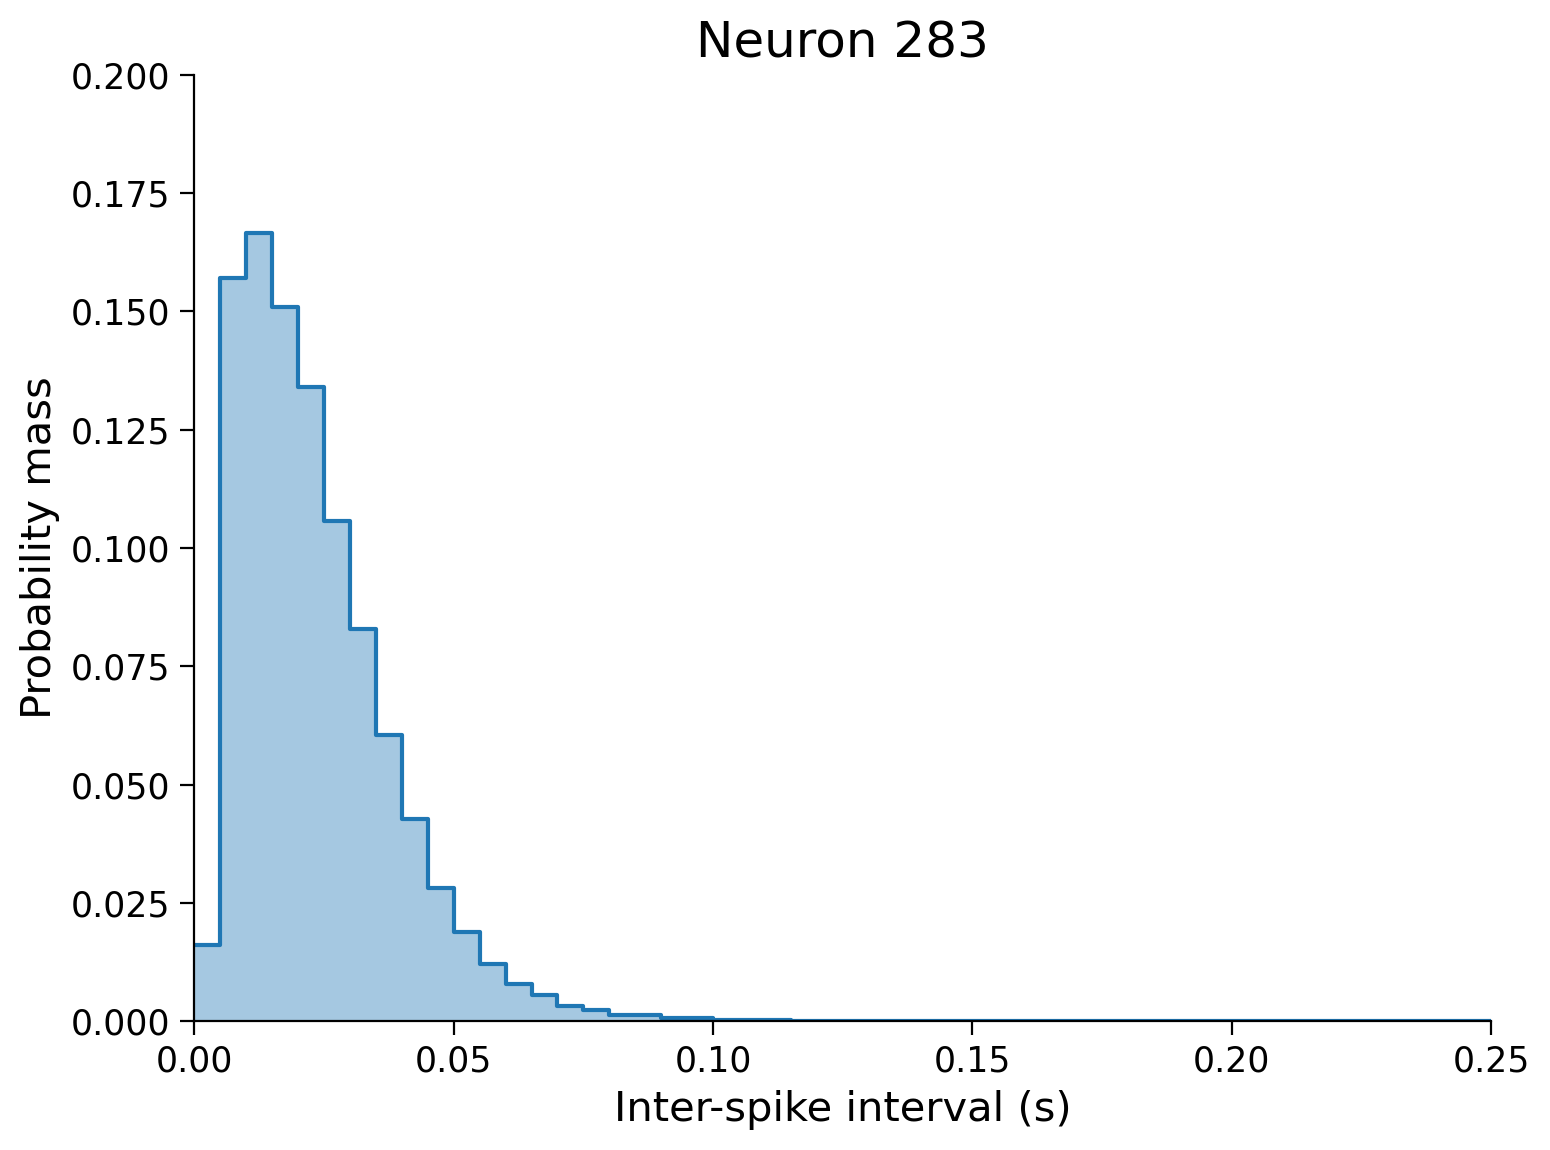

In [91]:
def pmf_from_counts(counts):
    """Given counts, normalize by the total to estimate probabilities."""

    pmf = counts / np.sum(counts)

    return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(spike_times[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf,isi_range)

### Section 3.2: Calculating entropy from pmf

In [92]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


In [94]:
def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
    """Given a discrete distribution, return the Shannon entropy in bits."""
    # remove non-zero entries to avoid an error from log2(0)
    pmf = pmf[pmf > 0]
    h = -np.sum(pmf * np.log2(pmf))
    # absolute value applied to avoid getting a -0 result
    return np.abs(h)

@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(spike_times)-1)))
def steinmetz_pmf(neuron):
    """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
    isi = np.diff(spike_times[neuron])
    bins = np.linspace(*isi_range, n_bins + 1)
    counts, _ = np.histogram(isi, bins)
    pmf = _pmf_from_counts(counts)

    plot_pmf(pmf,isi_range)
    plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…

### Bonus Section 1: The foundations for entropy